# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants pose questions to the given answers to win money. For this project, let's imagine we want to compete on Jeopardy and we're looking for any way to win. We will work with a set of Jeopardy questions to determine some patterns in the questions that could help us wing. 

## Dataset

The datasest contains 20000 rows and is available [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file). Each row represents a single question on a single episode of Jeopardy. The columns are

- ```Show Number``` - the Jeopardy episode number
- ```Air Date``` - the date the episode aired
- ```Round``` - the round of Jeopardy
- ```Category``` - the category of the question
- ```Value``` - the number of dollars the correct answer is worth
- ```Question``` - the text of the question
- ```Answer``` - the text of the answer


In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14
    )


% matplotlib inline

In [2]:
jeopardy = pd.read_csv('jeopardy.csv')

In [3]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [4]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [5]:
# let's remove the spaces in the column names, including
# some leading spaces

jeopardy.rename(columns={'Show Number': 'ShowNumber',
                       ' Air Date': 'AirDate',
                        ' Round': 'Round',
                        ' Category': 'Category',
                        ' Value': 'Value',
                        ' Question': 'Question',
                        ' Answer': 'Answer'},inplace=True)

jeopardy.columns

Index(['ShowNumber', 'AirDate', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [6]:
jeopardy.dtypes

ShowNumber     int64
AirDate       object
Round         object
Category      object
Value         object
Question      object
Answer        object
dtype: object

In [7]:
jeopardy.describe()

,ShowNumber
count,19999.000000
mean,4312.730537
std,1374.121672
min,10.000000
25%,3393.000000
50%,4582.000000
75%,5431.000000
max,6294.000000


In [8]:
jeopardy['Value'].value_counts()

$400       3892
$800       2980
$200       2784
$600       1890
$1000      1796
$2000      1074
$1200      1069
$1600      1027
$100        804
$500        798
$300        764
None        336
$1,000      184
$2,000      149
$3,000       70
$1,500       50
$1,200       42
$4,000       32
$5,000       23
$1,800       22
$1,400       20
$1,600       19
$2,500       18
$700         15
$2,200       11
$3,600        8
$2,400        8
$7,000        7
$6,000        7
$1,300        6
           ... 
$3,800        2
$4,800        2
$12,000       2
$750          1
$5,200        1
$4,500        1
$1,111        1
$3,389        1
$367          1
$3,300        1
$1,020        1
$4,700        1
$2,021        1
$2,300        1
$5,800        1
$7,500        1
$2,127        1
$6,200        1
$7,400        1
$2,900        1
$5,400        1
$6,100        1
$6,800        1
$10,800       1
$4,100        1
$9,000        1
$8,200        1
$1,492        1
$1,700        1
$3,900        1
Name: Value, Length: 76,

## Normalizing Text

Before we start our analysis, we need to normalize the text of the ```Question``` and ```Answer``` columns. In short, we want to put all words in lowercase and remove punctuation so that we don't consider words such as ```Don't``` and ```don't``` different words.

To do this, we will write a function that takes a strings, converts to lowercase, removes punctuation, and returns the string. 

In [40]:
def normalize_text(string):
    '''
    INPUT: string
    OUTPUT: string converted to lowercase 
    with puncuation removed
    '''
    lower_string = string.lower()
    
    
    new_string = re.sub(r'[^\w\s]', '', lower_string)

    return(new_string)
    


In [10]:
# test the function

normalize_text('WE",aEFasd;.>RS')

'weaefasdrs'

In [11]:
# apply function to the Question and the Answer columns

jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)

jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

## Normalizing Columns

There are a few other columns we need to normalize as well before we start the analysis. The ```Value``` column should be numeric, so we will remove the $ sign and convert to float. And the ```AirDate``` column should be a datetime. These will both be easier to work with after these changes.

In [12]:
def normalize_dollar_values(string):
    '''
    INPUT: string with dollar sign
    OUTPUT: integer
    '''
    # we will remove any punctuation to account for any
    # data entry issues
    new_string = re.sub(r'[^\w\s]', '', string)
    
    # convert to an integer
    try:
        now_an_int = int(new_string)
    except:
        now_an_int = 0
        
    return(now_an_int)

In [13]:
normalize_dollar_values('$3,000')

3000

In [14]:
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_dollar_values)

In [15]:
# convert the AirDate column to a datetime

jeopardy['AirDate'] = pd.to_datetime(jeopardy['AirDate'])

In [16]:
jeopardy.dtypes

ShowNumber                 int64
AirDate           datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

## Answers in Questions

In order to determine whether to study past questions, study general knowledge, or not study at all, it would be helpful to figure out two things:

- How often the answer can be used for a question
- How often questions are repeated

We can answer the first question by seeing how many times words in the answer also occur in the question. We can ansewr the second question by seeing how often complex words (>6 characters) reoccur.

Let's focus on this first task. 

In [17]:
def answer_in_question(row):
    
    # split the clean_answer column around spaces
    split_answer = row["clean_answer"].split()

    # split the clean_question columns around spaces
    split_question = row["clean_question"].split()

    match_count = 0
    if 'the' in split_answer:
        split_answer.remove('the')

    if len(split_answer) == 0:
        return(0)

    for word in split_answer:
        if word in split_question:
            match_count += 1
            
    return(match_count/len(split_answer))
    
    

In [18]:
# test the above function
#print(jeopardy.iloc[[3,5]])
#answer_in_question(jeopardy.iloc[[5]])

In [19]:
jeopardy['answer_in_question'] = jeopardy.apply(answer_in_question,
                                               axis=1)

In [20]:
# Find mean of 
jeopardy['answer_in_question'].mean()

0.05900196524977763

The answer only makes up about 6% of the question, on average. This means that just listening to the question will not give you a good clue to what the answer is going to be. We will need a different strategy to prepare for Jeopardy. 

## Recycled Questions

Now let's answer the second question from above. How often are new questions repeats of older questions? We should not that we are only using about 10% of the full Jeopardy question dataset, but we can still get an idea if this might be fruitful. 

In [21]:
question_overlap = []
terms_used = set()

# sort dataframe by ascending air date
jeopardy.sort_values(by=['AirDate'],inplace=True)

In [22]:
# we can use head and tail to confirm we sorted in 
# the correct direction
jeopardy.tail()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question
1953,6294,2012-01-19,Double Jeopardy!,WEAPONS OF WORLD WAR II,$800,"Ships in the U.S. Navy's Casablanca class of ""...",aircraft carriers,ships in the us navys casablanca class of esco...,aircraft carriers,800,0.0
1954,6294,2012-01-19,Double Jeopardy!,ACTING PRESIDENTS ON TV,$800,Dennis Haysbert & D.B. Woodside as David & Way...,24,dennis haysbert db woodside as david wayne p...,24,800,0.0
1955,6294,2012-01-19,Double Jeopardy!,4 N,$800,"""U"" know it means not deliberate; I'm sorry, t...",unintentional,u know it means not deliberate im sorry that s...,unintentional,800,0.0
1945,6294,2012-01-19,Double Jeopardy!,AMERICAN HISTORY,$400,In December 1974 this former New York governor...,Rockefeller,in december 1974 this former new york governor...,rockefeller,400,0.0
1922,6294,2012-01-19,Jeopardy!,THAT'S BUSINESS,$400,In 1997 Tyco International moved to this U.K. ...,Bermuda,in 1997 tyco international moved to this uk te...,bermuda,400,0.0


In [23]:
# loop through each row

for i, row in jeopardy.iterrows():
    split_question = row['clean_question'].split(" ")
    split_question = [x for x in split_question if len(x) > 5]
    
    match_count = 0
    
    for word in split_question:
        if word in terms_used:
            match_count += 1
        terms_used.add(word)
    if len(split_question) > 0:
        match_count /= len(split_question)
    question_overlap.append(match_count)

jeopardy["question_overlap"] = question_overlap

jeopardy["question_overlap"].mean()

    
    

0.6894006357823182

Almost 70% of words have been reclycled from previous questions. While this only includes part of the whole Jeopardy dataset and does not include phrases, it could indicate that it is worth a closer look at the reclycling of questions. 

## Low Value vs High Value Questions

One potential way to study questions would be to focus only on the high value (>800 pts) questions. This strategy could help us earn more money when on Jeopardy. We can use a chi-squared test to determine which terms correspond to high value questions.

First, we need to break the questions into two categories:
- Low value -- any row where ```Value``` is less than 800
- High value -- any row where ```Value``` is greater than 800.

We can loop through ```terms_used``` run a chi-squared test to find the words with the biggest differences in usage between high and low value questions. 

In [24]:
def determine_value(row):
    if row['clean_value'] > 800:
        value = 1
    else:
        value = 0
    return value

In [25]:
jeopardy['high_value'] = jeopardy.apply(determine_value,axis=1)

In [30]:
jeopardy['high_value'].value_counts()

0    14265
1     5734
Name: high_value, dtype: int64

In [31]:
def count_usage(word):
    low_count = 0
    high_count = 0
    for i,row in jeopardy.iterrows():
        if word in row['clean_question'].split(' '):
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [32]:
len(terms_used)

24470

In [37]:

terms_used_list = list(terms_used)
comparison_terms = [np.random.choice(terms_used_list) for _ in range(200)]

observed_expected = []


for term in comparison_terms:
    observed_expected.append(count_usage(term))

observed_expected


[(1, 0),
 (1, 0),
 (0, 2),
 (0, 1),
 (0, 3),
 (2, 5),
 (1, 0),
 (1, 0),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (3, 12),
 (0, 1),
 (0, 1),
 (11, 10),
 (27, 47),
 (0, 1),
 (0, 1),
 (0, 3),
 (1, 0),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 4),
 (1, 4),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 2),
 (1, 0),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 2),
 (0, 1),
 (1, 0),
 (1, 0),
 (4, 3),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (1, 0),
 (0, 2),
 (7, 15),
 (1, 0),
 (1, 0),
 (0, 5),
 (1, 0),
 (0, 1),
 (4, 5),
 (0, 1),
 (0, 1),
 (36, 79),
 (0, 1),
 (1, 2),
 (3, 3),
 (0, 2),
 (1, 0),
 (0, 1),
 (1, 6),
 (0, 1),
 (1, 0),
 (2, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (8, 9),
 (1, 6),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (1, 0),
 (0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 3),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 2),
 (61, 186),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (4, 19),
 (0, 1),
 (1, 0),
 (0, 1)

In [38]:
high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]

chi_squared = []
p_value = []

for pair in observed_expected:
    total = pair[0] + pair[1]
    total_prop = total / jeopardy.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([pair[0], pair[1]])
    expected = np.array([high_value_exp, low_value_exp])
     
    #chi_squared.append(chisquare(observed, expected))
    chi_sq,p_val = chisquare(observed,expected)
    chi_squared.append(chi_sq)
    p_value.append(p_val)

    
#chi_squared
#p_value


/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



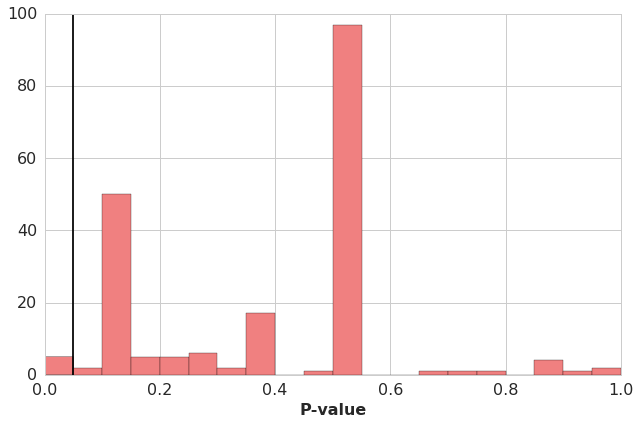

In [39]:
bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,
       0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

plt.figure(figsize=(9,6))

plt.hist(p_value,bins=bins,color='lightcoral')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('P-value',fontsize=16)

plt.axvline(x=0.05,color='k')
plt.show()